# Loading the Libraries

In [6]:
import numpy as np
from google.colab import drive
import cv2,os
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from keras.models import load_model
from matplotlib import pyplot as plt
import tensorflow as tf
!pip install git+git://github.com/PnS2019/pnslib.git
from pnslib import utils
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import argparse
import glob

  Cloning git://github.com/PnS2019/pnslib.git to /tmp/pip-req-build-w9u2f6bw
  Running command git clone -q git://github.com/PnS2019/pnslib.git /tmp/pip-req-build-w9u2f6bw
  Created wheel for pnslib: filename=pnslib-0.1.0a1-cp36-none-any.whl size=1489619 sha256=9f61f3777fd1988ea4cb8a4e623ed9e8ab9c77c7a90a24a4d1aaa8cdfd0f2b19
  Stored in directory: /tmp/pip-ephem-wheel-cache-zvpepo33/wheels/a2/8e/a9/c62e72840009deaa723b3a113d5c3b90acac77098d16e90eca
Successfully built pnslib


In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
data_path="/content/gdrive/My Drive/face-mask-detector/dataset"
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary

print(label_dict)
print(categories)
print(labels)

{'with_mask': 0, 'without_mask': 1}
['with_mask', 'without_mask']
[0, 1]


# auto_canny function helps us determine unique canny threshold for each image

In [8]:
def auto_canny(image, sigma=0.33):
	v = np.median(image)
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	return edged

#Loading the dataset
## auto_canny function is applied on the images to determine the unique threshold

In [20]:
img_size=100
data=[]
target=[]


for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)

        try:
            
            gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)           
            #Coverting the image into gray scale
            resized=cv2.resize(gray,(img_size,img_size))
            wide = cv2.Canny(resized, 10, 200)
            tight = cv2.Canny(resized, 225, 250)
            edges= auto_canny(resized)
	          
            resized1=cv2.resize(edges,(img_size,img_size))
            data.append(resized1)
            target.append(label_dict[category])
            print('.',end=' ')
            #appending the image and the label(categorized) into the list (dataset)

        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [21]:
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)

from keras.utils import np_utils

new_target=np_utils.to_categorical(target)

In [22]:
np.save('data',data)
np.save('target',new_target)
data=np.load('data.npy')
target=np.load('target.npy')

In [45]:
model=Sequential()
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [46]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')
history=model.fit(train_data,train_target,epochs=50,callbacks=[checkpoint],validation_split=0.2)

Epoch 1/50
31/31 [==============================] - 2s 56ms/step - loss: 0.6759 - accuracy: 0.5717 - val_loss: 0.5745 - val_accuracy: 0.8347
Epoch 2/50
31/31 [==============================] - 2s 57ms/step - loss: 0.5121 - accuracy: 0.7343 - val_loss: 0.3668 - val_accuracy: 0.8508
Epoch 3/50
31/31 [==============================] - 2s 51ms/step - loss: 0.3934 - accuracy: 0.8364 - val_loss: 0.2873 - val_accuracy: 0.9032
Epoch 4/50
31/31 [==============================] - 2s 50ms/step - loss: 0.3011 - accuracy: 0.8828 - val_loss: 0.2048 - val_accuracy: 0.9153
Epoch 5/50
31/31 [==============================] - 2s 56ms/step - loss: 0.2593 - accuracy: 0.8939 - val_loss: 0.1847 - val_accuracy: 0.9355
Epoch 6/50
31/31 [==============================] - 0s 13ms/step - loss: 0.2314 - accuracy: 0.9030 - val_loss: 0.2156 - val_accuracy: 0.9234
Epoch 7/50
31/31 [==============================] - 0s 13ms/step - loss: 0.2436 - accuracy: 0.8960 - val_loss: 0.2334 - val_accuracy: 0.9234
Epoch 8/50
31

In [47]:
print(model.evaluate(test_data,test_target))

5/5 [==============================] - 0s 16ms/step - loss: 0.4021 - accuracy: 0.9420
[0.40214818716049194, 0.9420289993286133]


In [57]:
model.save("/content/sid_median_canny.h5")

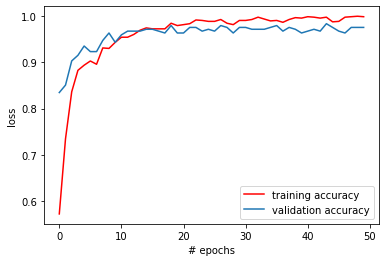

In [55]:
plt.plot(history.history['accuracy'],'r',label='training accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

#[1,0] --> Mask
#[0,1] --> No Mask

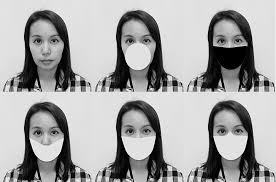

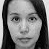

[[0. 1.]]


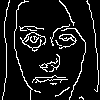

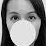

[[1. 0.]]


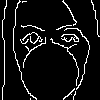

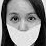

[[1. 0.]]


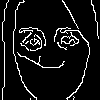

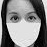

[[1. 0.]]


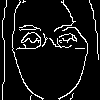

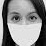

[[1. 0.]]


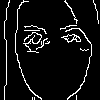

In [52]:
frame = cv2.imread("/content/555.jpg", 0)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')


detections = face_cascade.detectMultiScale(frame)  #This will give all regions where it thinks there is a face
ROI_number = 0
for i in range(len(detections)):
  (x,y,w,h) = detections[i]
  roi = frame[y:y+h, x:x+w]
  cv2.imwrite('/content/ROI_{}.jpg'.format(ROI_number), roi)
  ROI_number += 1

cv2_imshow(frame)
cv2.waitKey(0)
for i in range(ROI_number):
  img1 = cv2.imread('/content/ROI_{}.jpg'.format(i))
  cv2_imshow(img1)
  
  gray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
  resized=cv2.resize(gray,(100,100))
  wide = cv2.Canny(resized, 10, 200)
  tight = cv2.Canny(resized, 225, 250)
  edges= auto_canny(resized)
  reshaped=np.reshape(edges,(1,100,100,1))
  result=model.predict(reshaped)
  print(result)
  cv2_imshow(edges)

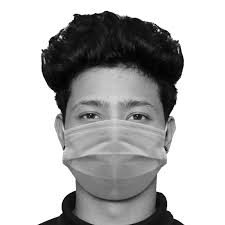

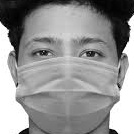

[[1. 0.]]


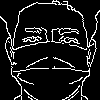

In [53]:
frame = cv2.imread("/content/22.jpg", 0)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')


detections = face_cascade.detectMultiScale(frame)  #This will give all regions where it thinks there is a face
ROI_number = 0
for i in range(len(detections)):
  (x,y,w,h) = detections[i]
  roi = frame[y:y+h, x:x+w]
  cv2.imwrite('/content/ROI_{}.jpg'.format(ROI_number), roi)
  ROI_number += 1

cv2_imshow(frame)
cv2.waitKey(0)
for i in range(ROI_number):
  img1 = cv2.imread('/content/ROI_{}.jpg'.format(i))
  cv2_imshow(img1)
  
  gray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
  resized=cv2.resize(gray,(100,100))
  wide = cv2.Canny(resized, 10, 200)
  tight = cv2.Canny(resized, 225, 250)
  edges= auto_canny(resized)
  reshaped=np.reshape(edges,(1,100,100,1))
  result=model.predict(reshaped)
  print(result)
  cv2_imshow(edges)

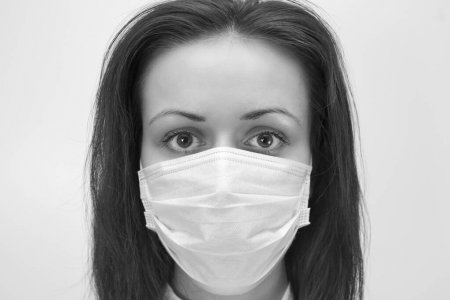

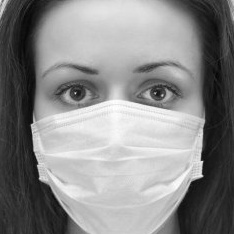

[[1. 0.]]


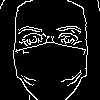

In [60]:
frame = cv2.imread("/content/88.jpg", 0)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')


detections = face_cascade.detectMultiScale(frame)  #This will give all regions where it thinks there is a face
ROI_number = 0
for i in range(len(detections)):
  (x,y,w,h) = detections[i]
  roi = frame[y:y+h, x:x+w]
  cv2.imwrite('/content/ROI_{}.jpg'.format(ROI_number), roi)
  ROI_number += 1

cv2_imshow(frame)
cv2.waitKey(0)
for i in range(ROI_number):
  img1 = cv2.imread('/content/ROI_{}.jpg'.format(i))
  cv2_imshow(img1)
  
  gray=cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
  resized=cv2.resize(gray,(100,100))
  wide = cv2.Canny(resized, 10, 200)
  tight = cv2.Canny(resized, 225, 250)
  edges= auto_canny(resized)
  reshaped=np.reshape(edges,(1,100,100,1))
  result=model.predict(reshaped)
  print(result)
  cv2_imshow(edges)